### This code using annotations file randomly downloads 18000 images from coco dataset website

In [1]:
import os
import json
import random
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# === Configurations ===
ANNOTATIONS_PATH = "annotations/instances_train2017.json"
OUTPUT_DIR = "train2017_subset"
NUM_IMAGES = 18000
NUM_WORKERS = 64
COCO_IMAGE_URL = "http://images.cocodataset.org/train2017/"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load COCO annotations
with open(ANNOTATIONS_PATH, 'r') as f:
    coco_data = json.load(f)

all_images = coco_data['images']
print(f"Total images available: {len(all_images)}")

# Randomly select 18000 images
selected_images = random.sample(all_images, NUM_IMAGES)

# Save selected image info
with open("selected_images.json", "w") as f:
    json.dump(selected_images, f)

# Define image downloader
def download_image(img):
    file_name = img['file_name']
    url = COCO_IMAGE_URL + file_name
    path = os.path.join(OUTPUT_DIR, file_name)

    if os.path.exists(path):
        return file_name, "exists"

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        with open(path, 'wb') as f:
            f.write(response.content)
        return file_name, "downloaded"
    except Exception as e:
        return file_name, f"error: {str(e)}"

# Parallel download
print("Starting image download...")
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    futures = [executor.submit(download_image, img) for img in selected_images]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
        file_name, status = future.result()
        if "error" in status:
            print(f"Failed: {file_name} => {status}")


Total images available: 118287
Starting image download...


Downloading: 100%|██████████| 18000/18000 [06:45<00:00, 44.40it/s]


### This code generates masks for each of the downloaded image in above and resizes both images and their masks into 256x256 and saves them into resized_images and resized_masks respectively

In [4]:
import os
import json
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm

# === Paths ===
ANNOTATIONS_PATH = "instances_train2017.json"
IMAGE_DIR = "train2017_subset"  # Your 18k subset
OUTPUT_IMG_DIR = "resized_images"
OUTPUT_MASK_DIR = "resized_masks"
RESIZE_SHAPE = (256, 256)

# === Create output dirs ===
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# === Load annotations ===
coco = COCO(ANNOTATIONS_PATH)

# === Get only the image IDs for the 18k subset ===
subset_image_files = set(os.listdir(IMAGE_DIR))
subset_image_ids = [
    img['id'] for img in coco.dataset['images']
    if img['file_name'] in subset_image_files
]

# === Loop through and generate masks ===
for img_id in tqdm(subset_image_ids, desc="Processing images + masks"):
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    img_path = os.path.join(IMAGE_DIR, file_name)

    # Load image
    image = Image.open(img_path).convert('RGB')
    image = image.resize(RESIZE_SHAPE, Image.BILINEAR)
    image.save(os.path.join(OUTPUT_IMG_DIR, file_name))

    # Generate segmentation mask
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']
        ann_mask = coco.annToMask(ann)
        mask[ann_mask == 1] = category_id

    # Resize mask
    resized_mask = cv2.resize(mask, RESIZE_SHAPE, interpolation=cv2.INTER_NEAREST)
    mask_path = os.path.join(OUTPUT_MASK_DIR, file_name.replace('.jpg', '.png'))
    cv2.imwrite(mask_path, resized_mask)


loading annotations into memory...
Done (t=13.03s)
creating index...
index created!


Processing images + masks: 100%|██████████| 18000/18000 [02:38<00:00, 113.23it/s]


### Below code is helpful for visualization of proceesed images and their corresponding original masks

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_coco_segmentation(image_path, mask_path, alpha=0.5):
    """
    Visualize segmentation with COCO-style coloring
    Args:
        image_path: Path to input image
        mask_path: Path to segmentation mask (grayscale PNG)
        alpha: Transparency level (0-1)
    """
    # Read image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Create color map (91 colors for COCO)
    colormap = cm.get_cmap('tab20', 91)
    
    # Normalize mask to 0-1 for colormap
    normalized_mask = mask / mask.max() if mask.max() > 0 else mask
    
    # Apply colormap to mask
    colored_mask = (colormap(normalized_mask)[:, :, :3] * 255).astype(np.uint8)
    
    # Blend image and mask
    result = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Segmentation Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



### visualizing few examples after generating masks using the written script

/tmp/ipykernel_349962/2513442630.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', 91)


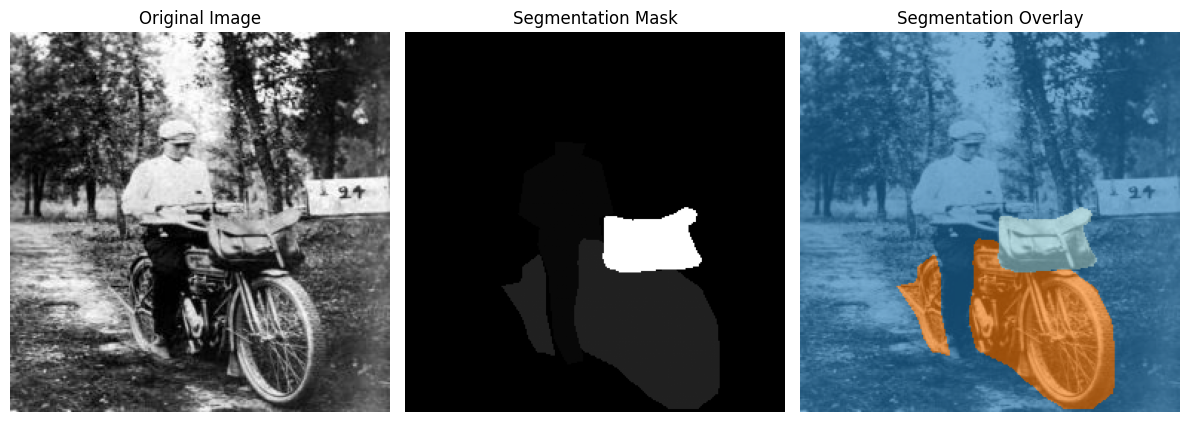

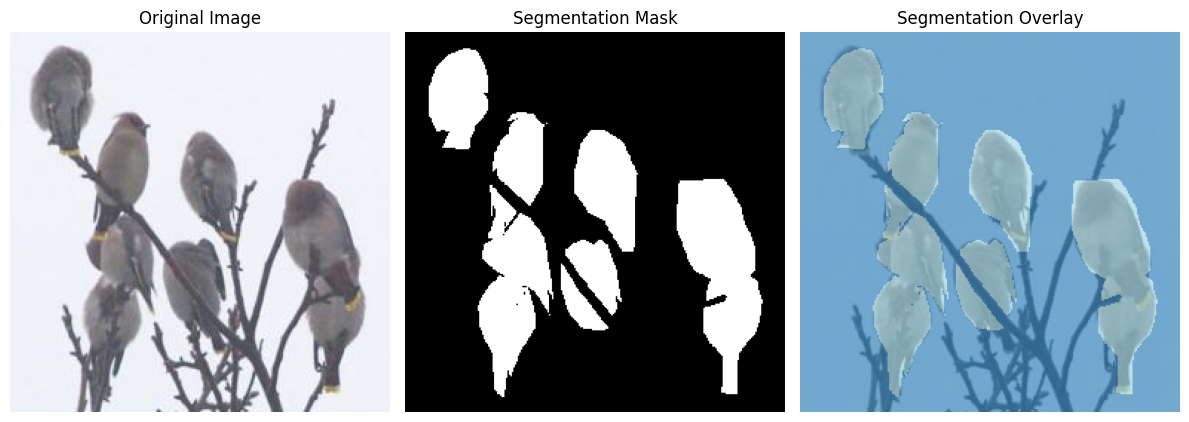

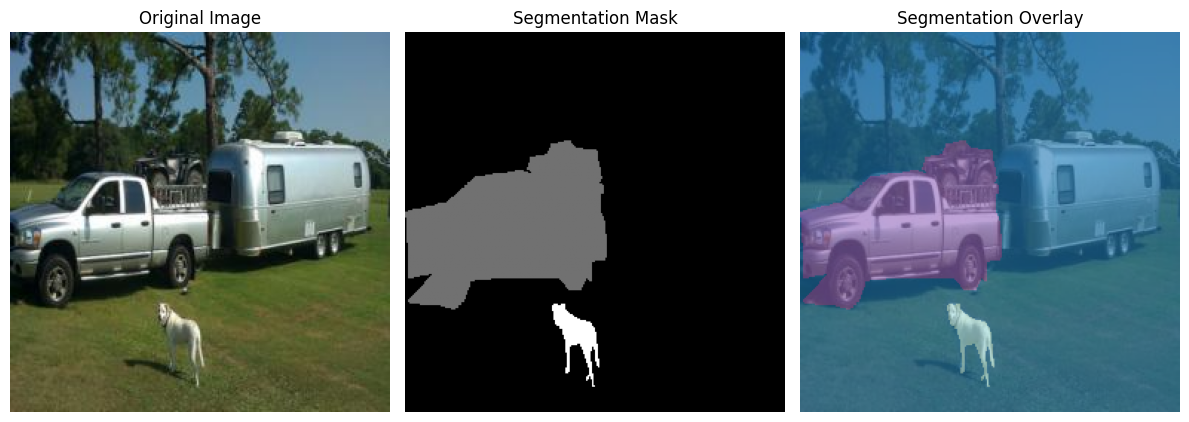

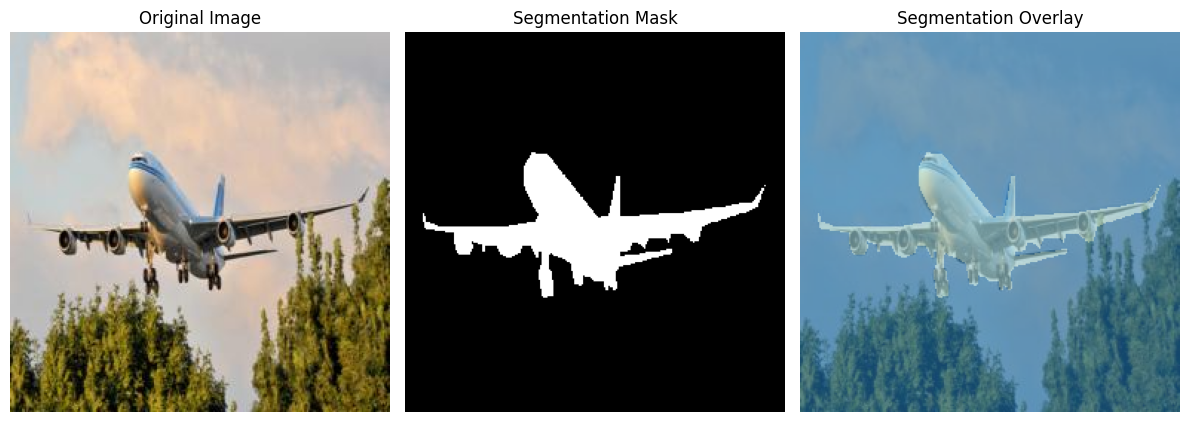

In [16]:

mask_path= "resized_masks/000000000086.png"  
image_path = "resized_images/000000000086.jpg"    
visualize_coco_segmentation(image_path, mask_path, alpha=0.6)

mask_path= "resized_masks/000000000143.png"  
image_path = "resized_images/000000000143.jpg"    
visualize_coco_segmentation(image_path, mask_path, alpha=0.6)


mask_path= "resized_masks/000000006197.png" 
image_path = "resized_images/000000006197.jpg"    
visualize_coco_segmentation(image_path, mask_path, alpha=0.6)


mask_path= "resized_masks/000000577795.png"  
image_path = "resized_images/000000577795.jpg"    
visualize_coco_segmentation(image_path, mask_path, alpha=0.6)

### The following is the code to train and evaluate deeplabv3 model with resnet50 as backbone for image segmentation task

In [ ]:
# Memory-optimized DeepLabV3 training loop with test predictions
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import math
import gc

# Configuration
DATA_DIR = ''  # Update this
IMAGE_DIR = os.path.join(DATA_DIR, 'resized_images')
MASK_DIR = os.path.join(DATA_DIR, 'resized_masks')
NUM_CLASSES = 91
BATCH_SIZE = 8
EPOCHS = 50
LR = 0.001
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = 'checkpoints'
PREDICTIONS_DIR = 'predictions'
NUM_WORKERS = 4
GRAD_ACCUM_STEPS = 2  # Gradient accumulation steps

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

# Memory optimization settings
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

scaler = torch.cuda.amp.GradScaler()

# def print_memory_stats(desc=""):
#     print(f"\nMemory Stats {desc}:")
#     print(f"Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
#     print(f"Reserved: {torch.cuda.memory_reserved()/1024**3:.2f} GB")
#     print(f"Max allocated: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

def find_latest_checkpoint():
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('model_epoch_') and f.endswith('.pth')]
    if not checkpoints:
        return None
    epoch_numbers = [int(f.split('_')[2].split('.')[0]) for f in checkpoints]
    latest_epoch = max(epoch_numbers)
    return os.path.join(CHECKPOINT_DIR, f'model_epoch_{latest_epoch}.pth')

# Dataset preparation
all_images = sorted(os.listdir(IMAGE_DIR))
all_masks = sorted(os.listdir(MASK_DIR))

train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=3000, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=3000, random_state=42)

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = [os.path.join(IMAGE_DIR, x) for x in image_paths]
        self.mask_paths = [os.path.join(MASK_DIR, x) for x in mask_paths]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])
        image = self.transform(image) if self.transform else image
        mask = torch.from_numpy(np.array(mask)).long()
        return image, mask, os.path.basename(self.image_paths[idx])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)
test_dataset = SegmentationDataset(test_images, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

# Model setup
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# Freeze backbone layers to save memory
for param in model.backbone.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss(ignore_index=255)  # Add ignore_index if you have void class
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

def calculate_batch_metrics(outputs, labels):
    """Calculate metrics batch-wise to save memory"""
    _, preds = torch.max(outputs, 1)
    correct_pixels = (preds == labels).sum()
    total_pixels = labels.numel()
    
    iou_sum = 0
    valid_classes = 0
    for class_id in range(NUM_CLASSES):
        pred_mask = (preds == class_id)
        true_mask = (labels == class_id)
        intersection = (pred_mask & true_mask).sum().float()
        union = (pred_mask | true_mask).sum().float()
        
        if union > 0:
            iou_sum += (intersection / union)
            valid_classes += 1
    
    return torch.tensor([correct_pixels, total_pixels, iou_sum, valid_classes], 
                       device='cpu', dtype=torch.float32)

def aggregate_metrics(metrics_list):
    """Aggregate batch-wise metrics"""
    metrics = torch.stack(metrics_list)
    total_correct = metrics[:, 0].sum()
    total_pixels = metrics[:, 1].sum()
    total_iou = metrics[:, 2].sum()
    total_valid = metrics[:, 3].sum()
    
    pixel_acc = total_correct / total_pixels
    mean_iou = total_iou / total_valid if total_valid > 0 else 0
    return pixel_acc.item(), mean_iou.item()

def predict_and_save(model, dataloader, device, output_dir):
    """Generate and save predictions for a dataset"""
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for images, _, image_names in tqdm(dataloader, desc="Generating predictions"):
            images = images.to(device, non_blocking=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for i in range(preds.shape[0]):
                pred_mask = preds[i]
                img_name = image_names[i]
                np.save(os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}.npy"), pred_mask)
    
    print(f"Predictions saved to {output_dir}")

# Training setup
start_epoch = 0
best_val_iou = 0.0
latest_checkpoint = find_latest_checkpoint()
if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint, map_location=DEVICE)
    model.load_state_dict(checkpoint)
    del checkpoint  # Free memory
    gc.collect()
    
    state_file = latest_checkpoint.replace('model_epoch_', 'training_state_')
    if os.path.exists(state_file):
        state = torch.load(state_file, map_location=DEVICE)
        start_epoch = state['epoch'] + 1
        best_val_iou = state['best_val_iou']
        del state
        gc.collect()

# Main training loop
for epoch in range(start_epoch, EPOCHS):
    # print_memory_stats(f"Before epoch {epoch+1}")
    
    # Training phase
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    for i, (images, masks, _) in enumerate(tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{EPOCHS}')):
        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast():
            outputs = model(images)['out']
            loss = criterion(outputs, masks) / GRAD_ACCUM_STEPS

        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (i + 1) % GRAD_ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
    
    # Validation phase
    model.eval()
    val_metrics = []
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader, desc=f'Val Epoch {epoch+1}/{EPOCHS}'):
            images = images.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                val_loss += criterion(outputs, masks).item()
                batch_metrics = calculate_batch_metrics(outputs, masks)
                val_metrics.append(batch_metrics)
    
    # Calculate validation metrics
    val_pixel_acc, val_iou = aggregate_metrics(val_metrics)
    val_loss /= len(val_loader)
    scheduler.step(val_iou)
    
    # Save checkpoints
    checkpoint = {
        'epoch': epoch,
        'best_val_iou': best_val_iou,
        'val_loss': val_loss,
        'val_iou': val_iou
    }
    
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f'model_epoch_{epoch+1}.pth'))
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'training_state_{epoch+1}.pth'))
    
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_model.pth'))
        # Generate predictions with best model
        predict_and_save(model, test_loader, DEVICE, os.path.join(PREDICTIONS_DIR, f'epoch_{epoch+1}'))
    
    print(f"\nEpoch {epoch+1}:")
    print(f"Val Loss: {val_loss:.4f} | Pixel Acc: {val_pixel_acc:.4f} | mIoU: {val_iou:.4f}")
    # print_memory_stats(f"After epoch {epoch+1}")
    
    # Clean up
    del images, masks, outputs, checkpoint
    gc.collect()
    torch.cuda.empty_cache()  # Only call this once per epoch

# Generate final predictions
print("\nGenerating final test predictions...")
predict_and_save(model, test_loader, DEVICE, os.path.join(PREDICTIONS_DIR, 'final'))

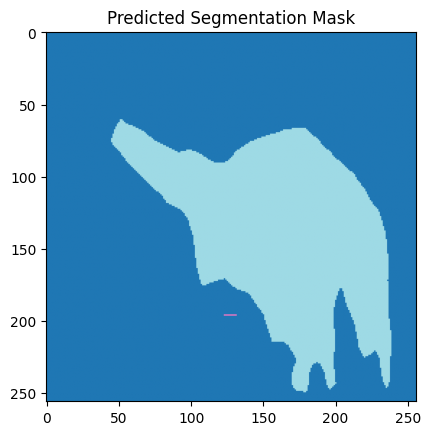

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mask = np.load('predictions/final/000000000144.npy')  # replace with actual path
plt.imshow(mask, cmap='tab20')  # or other colormap suited for label visualization
plt.title('Predicted Segmentation Mask')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import matplotlib.colors as mcolors

# A color palette for up to 80 classes
def get_color_palette(num_classes=91):
    colors = plt.cm.get_cmap('tab20', num_classes)
    return [colors(i)[:3] for i in range(num_classes)]

# Overlay mask with transparency on original image
def overlay_mask(image, mask, alpha=0.5, num_classes=80):
    palette = get_color_palette(num_classes)
    color_mask = np.zeros_like(image)

    for cls in np.unique(mask):
        if cls == 0:
            continue  # skip background
        color = (np.array(palette[cls % len(palette)]) * 255).astype(np.uint8)
        color_mask[mask == cls] = color

    overlay = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    return overlay

# Main visualization function
def visualize_image_and_mask(image_path, mask_path):
    # Load original image (RGB)
    image = np.array(Image.open(image_path).convert('RGB'))

    # Load predicted mask (class indices)
    mask = np.load(mask_path)

    # Overlay
    overlay = overlay_mask(image.copy(), mask)

    # Plot
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='nipy_spectral')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


### Now we have predictions and below few example visualizations of original and predicted masks

/tmp/ipykernel_4117806/4007010187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


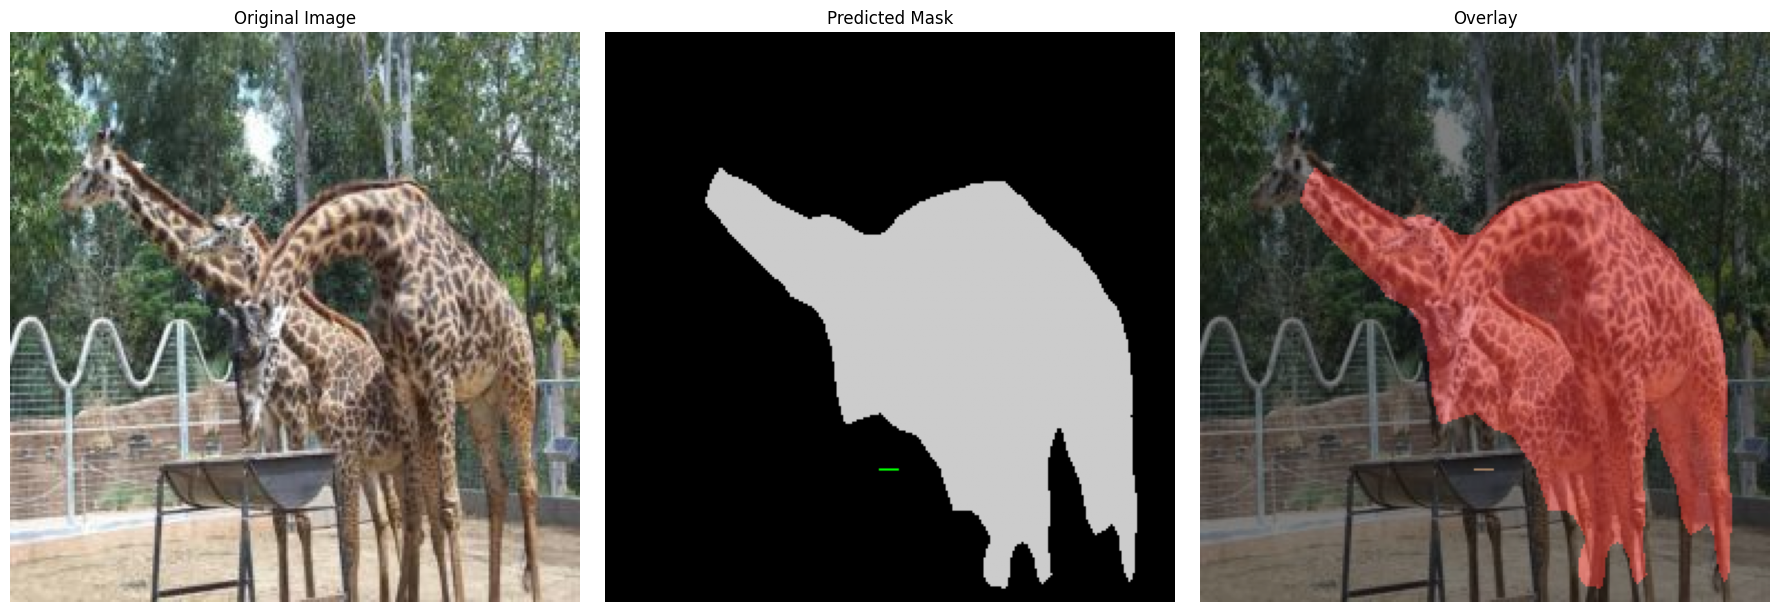

In [ ]:
image_path = 'resized_images/000000000144.jpg'           
mask_path = 'predictions/final/000000000144.npy'      

visualize_image_and_mask(image_path, mask_path)


/tmp/ipykernel_4117806/4007010187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


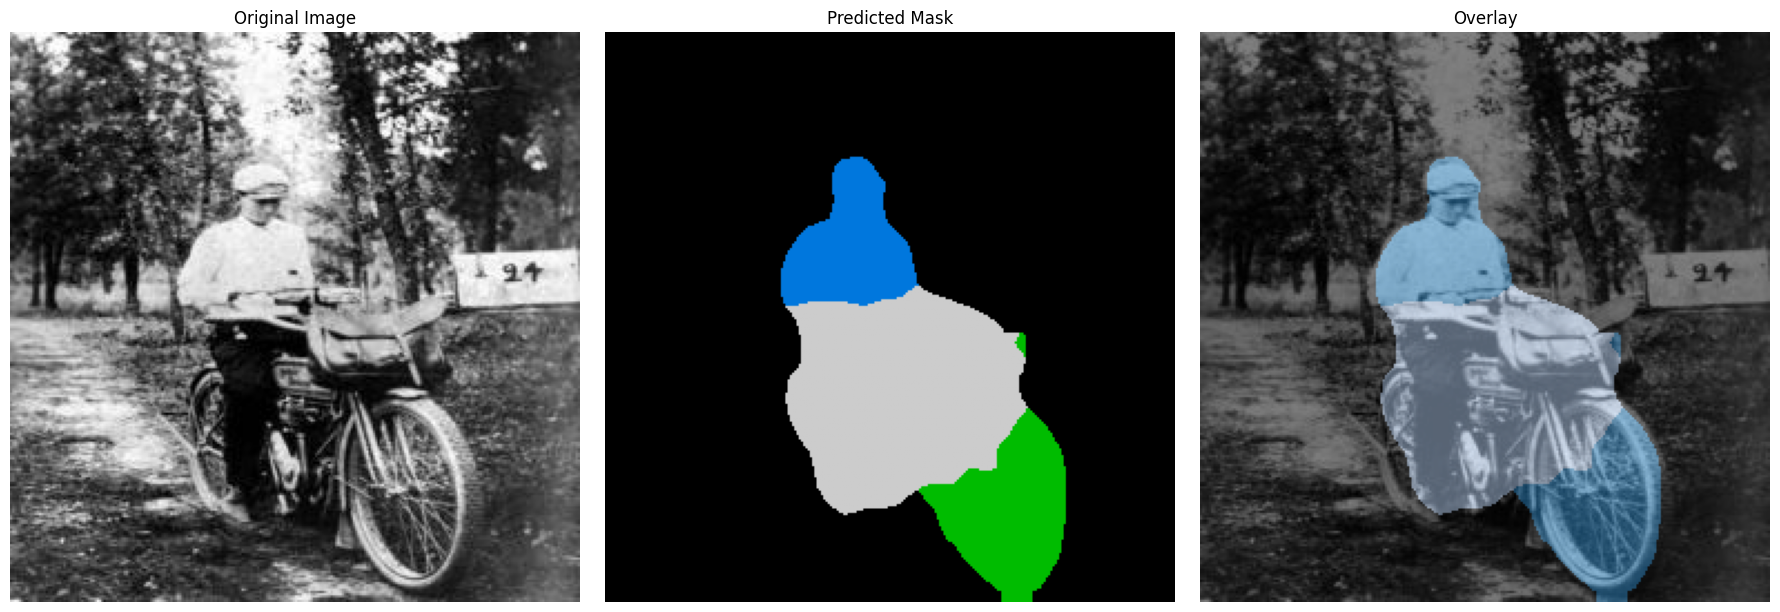

In [ ]:
image_path = 'resized_images/000000000086.jpg'           
mask_path = 'predictions1/final/000000000086.npy'       

visualize_image_and_mask(image_path, mask_path)


/tmp/ipykernel_4117806/4007010187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


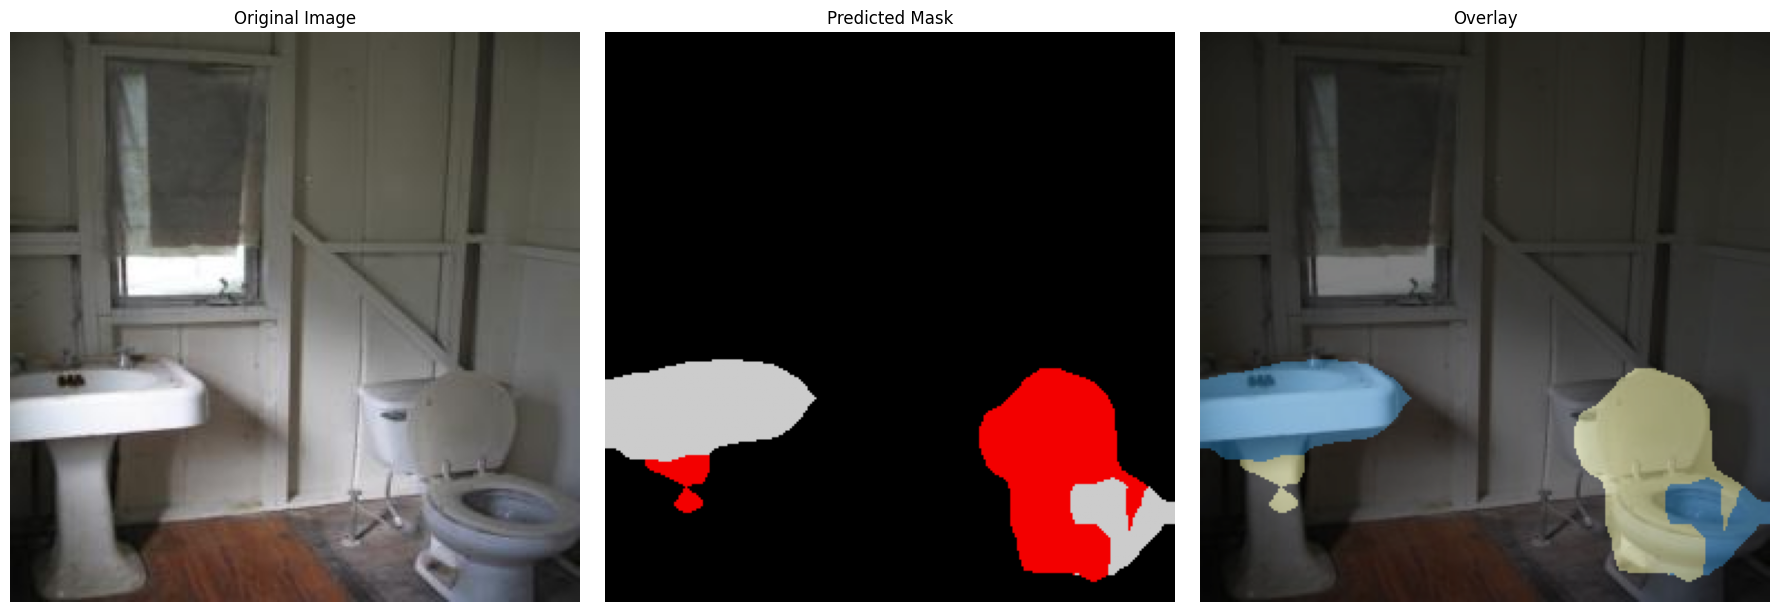

In [ ]:
image_path = 'resized_images/000000001213.jpg'           
mask_path = 'predictions/final/000000001213.npy'       

visualize_image_and_mask(image_path, mask_path)

/tmp/ipykernel_4117806/4007010187.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


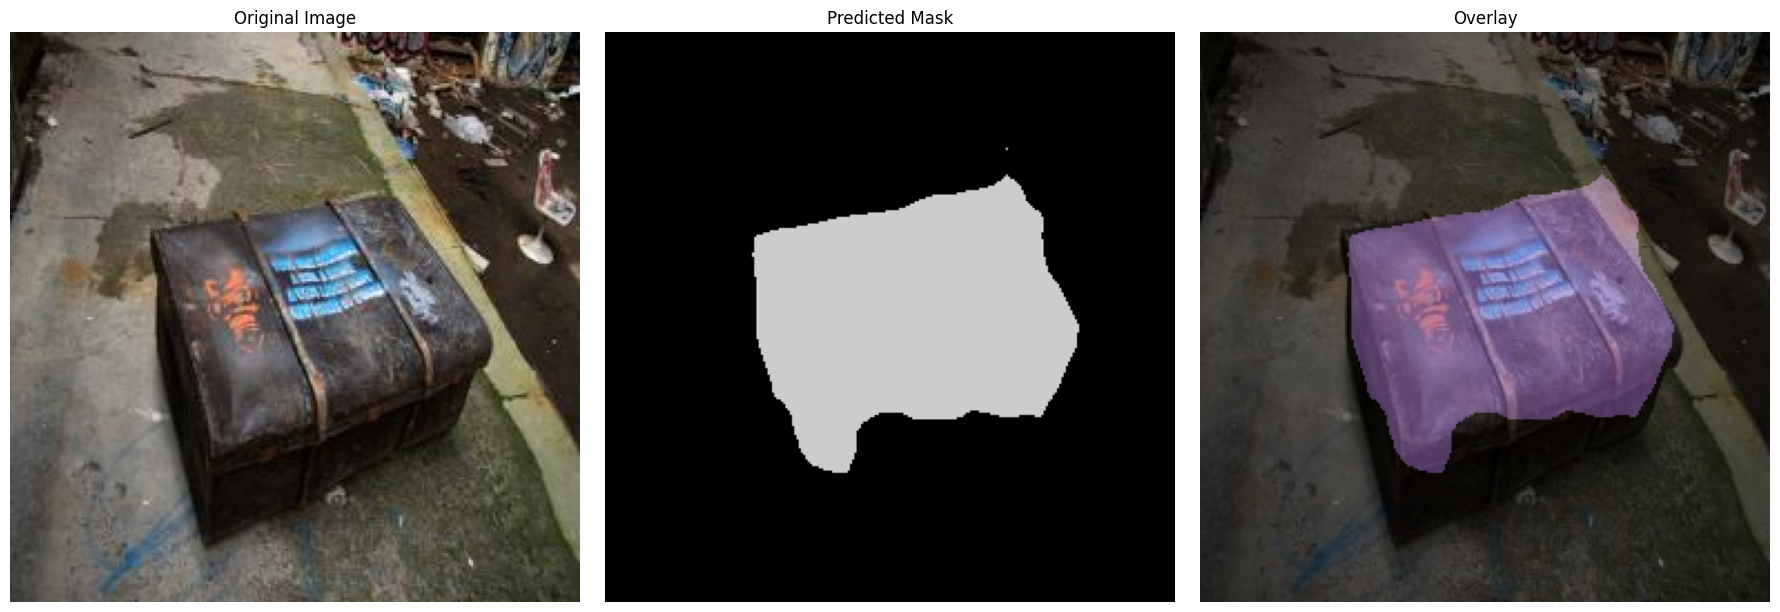

In [ ]:


image_path = 'resized_images/000000581906.jpg'           
mask_path = 'predictions/final/000000581906.npy'       
visualize_image_and_mask(image_path, mask_path)
